# Assignment 4 sklearn

With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions. 

#### Imports and inits

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score

from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation                            
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

### Define Utility Functions

#### Start global timer

In [2]:
tic = time.time()

#### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [4]:
y_name = 'high_priced'
x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

## Fit model

#### Split data into train and validation partitions 

In [5]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


#### train a decision tree

In [6]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split].dropna()

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 3052, columns = 23


In [7]:
# params dict for remediated models
rem_params = {'max_bins': 512,
              'max_interaction_bins': 16,
              'interactions': 10,
              'outer_bags': 4,
              'inner_bags': 0,
              'learning_rate': 0.001,
              'validation_size': 0.25,
              'min_samples_leaf': 5,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD, 
              'random_state': SEED}

rem_x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7781.


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [8]:
# best guess at feature distributions
schema_dict = {'term_360': {'p': 0.9, 'dist': 'binomial'},
               'conforming': {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std': {'p': 0.9, 'dist': 'binomial'},
               'loan_amount_std': {'min': -5, 'scale': 10, 'dist': 'exponential'},
               'intro_rate_period_std': {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std': {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std': {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'loan_to_value_ratio_std': {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'debt_to_income_ratio_std': {'mean': 0, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame
                            
np.random.seed(SEED) # same results each time cell is run    
    
for j in list(schema_dict.keys()): # loop through features
    
    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)
    
    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)
        
    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)
        
# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std'] 

#### First call to blackbox model for predictions on random data

In [9]:
blackbox_phat = pd.DataFrame(rem_ebm.predict(random_frame[x_names]), columns=['predictions']) 
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)

blackbox_phat

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,loan_to_value_ratio_std,debt_to_income_ratio_std,predictions
0,0,1,-4,7.848707,2.018107,4.448038,7.560986,2.346077,0.445795,0
1,1,1,0,49.480298,1.029955,4.580346,-1.530707,0.239296,-1.739534,0
2,1,1,-4,0.014153,2.853882,8.899881,13.705550,0.639075,0.779541,0
3,1,1,-4,7.912400,0.248822,8.887287,1.895881,0.087230,-0.292650,0
4,1,1,-4,-4.538403,1.796115,-2.252657,27.529353,1.263036,-0.066970,0
...,...,...,...,...,...,...,...,...,...,...
9995,1,0,-4,3.131098,0.858523,-1.989888,101.080853,3.217929,1.963579,0
9996,1,0,-4,20.817016,1.629730,1.545787,78.128700,0.781013,0.025907,0
9997,1,1,-4,13.417418,2.169186,-4.597814,4.196705,0.529789,0.526019,0
9998,1,1,-4,-0.195298,8.257270,-0.262736,33.229157,1.489432,-0.891872,0


#### Fit stolen decision tree model

In [10]:
stolen_dt = tree.DecisionTreeClassifier(max_depth=4)
X = blackbox_phat.drop('predictions', axis=1)
y = blackbox_phat['predictions']
stolen_dt = stolen_dt.fit(X, y)

#### View stolen decision tree model

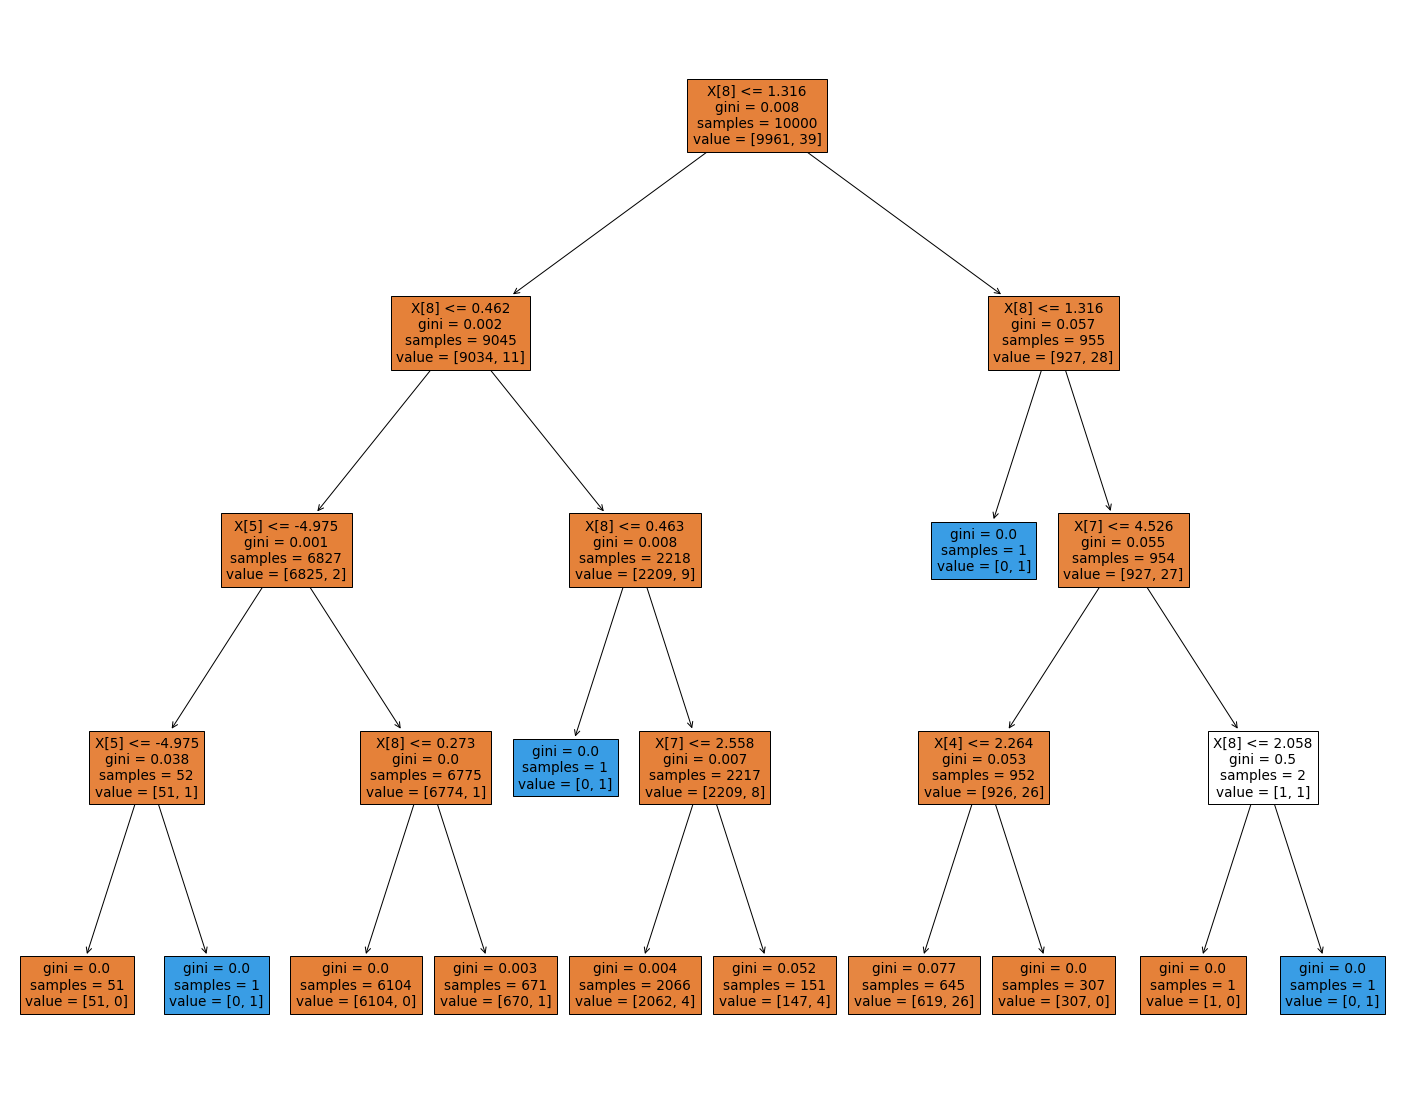

In [11]:
fig = plt.figure(figsize=(25,20))
sk_dt = tree.plot_tree(stolen_dt, filled=True)

#### Assess accuracy & feature importances of stolen model

In [12]:
roc_auc_score(y, stolen_dt.predict_proba(X)[:, 1])

0.9455105681388183

In [13]:
stolen_dt.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.0674451 ,
       0.19946725, 0.        , 0.10591764, 0.62717001])

In [14]:
import shap

shap.initjs()

  0%|          | 0/10000 [00:00<?, ?it/s]

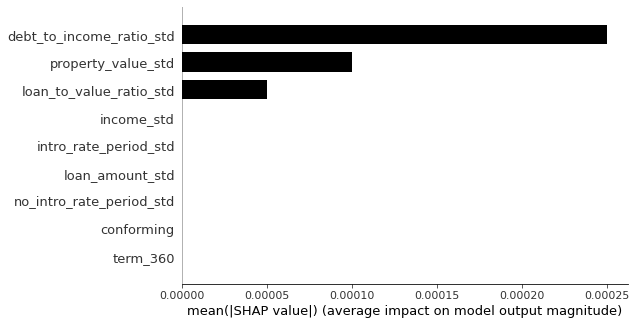

In [15]:
pred = stolen_dt.predict
summary = shap.kmeans(X, 50)
explainer = shap.KernelExplainer(pred, summary)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type='bar', color='k')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


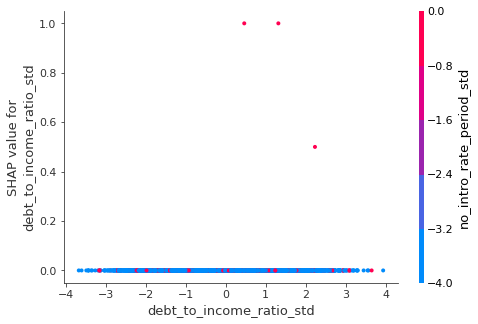

In [16]:
shap.dependence_plot(8, shap_values, X)

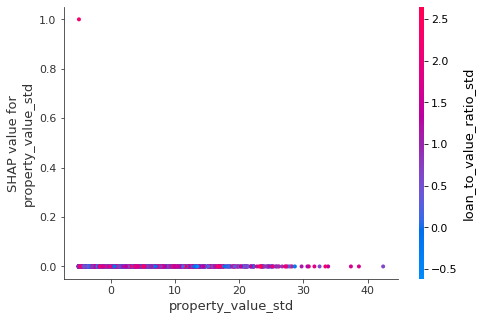

In [17]:
shap.dependence_plot(5, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


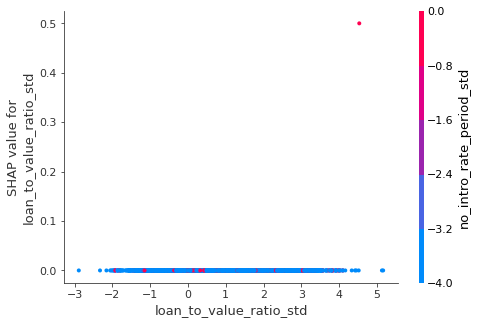

In [18]:
shap.dependence_plot(7, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


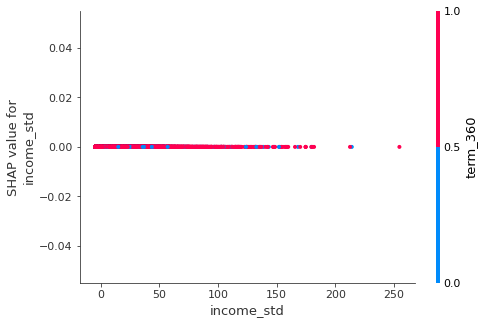

In [19]:
shap.dependence_plot(6, shap_values, X)

## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [20]:
low_adversary_seed = random_frame.loc[(random_frame['debt_to_income_ratio_std'] < 1.3) & 
                                      (random_frame['property_value_std'] >= 2.065) &
                                      (random_frame['loan_to_value_ratio_std'] < 0.8), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['debt_to_income_ratio_std'] >= 1.4) & 
                                      (random_frame['property_value_std'] < -0.7) &
                                      (random_frame['loan_to_value_ratio_std'] >= 1.1), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                     0.894040
conforming                   0.883002
no_intro_rate_period_std    -3.593819
loan_amount_std              5.117637
intro_rate_period_std        2.060622
property_value_std           6.981248
income_std                  21.007286
loan_to_value_ratio_std      0.085381
debt_to_income_ratio_std    -0.212915
dtype: float64

High adversarial example search seed row:
term_360                     0.840183
conforming                   0.881279
no_intro_rate_period_std    -3.616438
loan_amount_std              5.890908
intro_rate_period_std        2.046096
property_value_std          -3.053160
income_std                  22.743554
loan_to_value_ratio_std      1.969508
debt_to_income_ratio_std     1.917994
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [21]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# quantiles over which to search 
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5] 
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across three important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)): 
        for b in list(random_frame['loan_to_value_ratio_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                low_adversary_seed['property_value_std'] = a
                low_adversary_seed['loan_to_value_ratio_std'] = b
                low_adversary_seed['debt_to_income_ratio_std'] = c
                low_adversary_frame = low_adversary_frame.append(low_adversary_seed, 
                                                                     ignore_index=True, sort=False)
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,loan_to_value_ratio_std,debt_to_income_ratio_std
0,0.89404,0.883002,-3.593819,5.117637,2.060622,18.545693,21.007286,-1.29433,-2.408547
1,0.89404,0.883002,-3.593819,5.117637,2.060622,18.545693,21.007286,-1.29433,-1.650883
2,0.89404,0.883002,-3.593819,5.117637,2.060622,18.545693,21.007286,-1.29433,-1.290623
3,0.89404,0.883002,-3.593819,5.117637,2.060622,18.545693,21.007286,-1.29433,-0.681455
4,0.89404,0.883002,-3.593819,5.117637,2.060622,18.545693,21.007286,-1.29433,-0.011674


#### Perturb seed row to find high scoring adversarial examples

In [22]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# generate potential adversarial examples across three important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)): 
        for b in list(random_frame['loan_to_value_ratio_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                high_adversary_seed['property_value_std'] = a
                high_adversary_seed['loan_to_value_ratio_std'] = b
                high_adversary_seed['debt_to_income_ratio_std'] = c
                high_adversary_frame = high_adversary_frame.append(high_adversary_seed, 
                                                                       ignore_index=True, sort=False)
                    
# view potential high scoring adversarial examples
high_adversary_frame.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,loan_to_value_ratio_std,debt_to_income_ratio_std
0,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.946902,22.743554,3.322541,2.379210
1,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.946902,22.743554,3.322541,1.640487
2,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.946902,22.743554,3.322541,1.295961
3,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.946902,22.743554,3.322541,0.664197
4,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.946902,22.743554,3.322541,-0.011674


#### Second call to blackbox API to test adversarial examples

In [23]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat']) 
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,loan_to_value_ratio_std,debt_to_income_ratio_std,phat
110,0.894040,0.883002,-3.593819,5.117637,2.060622,-1.487777,21.007286,-0.259271,-2.408547,0.142893
100,0.894040,0.883002,-3.593819,5.117637,2.060622,-1.487777,21.007286,-1.294330,-2.408547,0.142893
120,0.894040,0.883002,-3.593819,5.117637,2.060622,-1.487777,21.007286,1.018130,-2.408547,0.142893
115,0.894040,0.883002,-3.593819,5.117637,2.060622,-1.487777,21.007286,0.347225,-2.408547,0.142893
105,0.894040,0.883002,-3.593819,5.117637,2.060622,-1.487777,21.007286,-0.615805,-2.408547,0.142893
...,...,...,...,...,...,...,...,...,...,...
216,0.840183,0.881279,-3.616438,5.890908,2.046096,-3.549113,22.743554,1.686577,1.640487,0.443752
156,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.734405,22.743554,2.644875,1.640487,0.443752
186,0.840183,0.881279,-3.616438,5.890908,2.046096,-4.468203,22.743554,2.325711,1.640487,0.443752
205,0.840183,0.881279,-3.616438,5.890908,2.046096,-3.549113,22.743554,2.644875,2.379210,0.443752


We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API. These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan. 

#### End timer

In [24]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 522.42 s.
